In [1]:
from data_reader import DataReader
import datasets
from tweet_to_vec import TweetToVec
import utils
from RNN import RNNModel
from evaluate import evaluate1
from evaluate import evaluate2
import os
import matplotlib.pyplot as plt

import torch
from tqdm import tqdm
import numpy as np
from torch import nn, optim
import torch.nn as nn

In [2]:
dr = DataReader('nlkt')
dr.read_dataset(datasets.binary_classes, False)
dr.read_dataset(datasets.ternary_classes, False)
embeddings = dr.read_embeddings('embeddings/kraby.txt', False)

binary_dataset = dr.get_dataset('binary')
binary_dataset = utils.extract_validation_from_training(binary_dataset)

ternary_dataset = dr.get_dataset('ternary')
ternary_dataset = utils.extract_validation_from_training(ternary_dataset)

In [6]:
def test(dataset, epochs, method, L, size, num_layers, prediction_method, equalize_training_classes, learning_rate, number_of_output_classes):
    batch_size = 32
    t2v = TweetToVec(embeddings, method, L)

    if equalize_training_classes:
        dataset = utils.equalize_training_classes(dataset)
    vectorized_dataset = t2v.vectorize_dataset(dataset)
    def gen_batched():
        batched_dataset = t2v.batch_dataset(vectorized_dataset, batch_size, True, True)
        return batched_dataset['training tweets'], batched_dataset['training tags']

    model = RNNModel(size=size, embedding_dim=100,num_layers=num_layers, number_of_output_classes=number_of_output_classes, L=L, prediction_method=prediction_method, learning_rate=learning_rate)

    batched = t2v.batch_dataset(vectorized_dataset, batch_size, True, False)
    tweets = batched['validation tweets']
    tags = batched['validation tags']
    current_best_score = 0
    best_model_path = ""
    params_string = f'_number_of_output_classes_{number_of_output_classes}_method_{method}_L_{L}_size_{size}_num_layers_{num_layers}_prediction_method_{prediction_method}_equalize_training_classes_{equalize_training_classes}_learnig_rate_{learning_rate}'
    
    scores = []

    for i in range(epochs):
        model.train_model(gen_batched, 1)
        model.eval()
        predictions = model.predict(tweets)
        score = 0
        if number_of_output_classes == 2:
            score = evaluate1(predictions, tags)['balancedf']
            print(" balancedf score on valid =", score)
        else:
            score = evaluate2(predictions, tags)['microAverageFscore']
            print(" microAverageFscore score on valid =", score)  
        scores.append(score)  
        if score > current_best_score:
            if len(best_model_path) > 0:
                os.remove(best_model_path)
            current_best_score = score
            str_score = str(score * 100)
            str_score = str_score[:min(len(str_score), 5)]
            best_model_path = 'models/RNN_' + str_score + params_string + '.model'
            torch.save(model.state_dict(), best_model_path)
    

    plt.plot(scores)
    plt.ylabel('scores on validation over epochs')
    plt.show()
    print("Best score = ", current_best_score)

In [7]:
def evaluate_on_test(filename, dataset, size, num_layers, L, prediction_method, method, number_of_output_classes):
    model = RNNModel(size=size, embedding_dim=100,num_layers=num_layers, number_of_output_classes=number_of_output_classes, L=L, prediction_method=prediction_method, learning_rate=0.0001)
    model.load_state_dict(torch.load(filename))
    model.eval()

    t2v = TweetToVec(embeddings, method, L)
    
    vectorized_dataset = t2v.vectorize_dataset(dataset)

    batched = t2v.batch_dataset(vectorized_dataset, 1, True, False)
    tweets = batched['test tweets']
    tags = batched['test tags']

    predictions = model.predict(tweets)
    if number_of_output_classes == 2:
        score = evaluate1(predictions, tags)['balancedf']
        print(" balancedf score on test =", score)
    else:
        score = evaluate2(predictions, tags)['microAverageFscore']
        print(" microAverageFscore score on test =", score)

## Hyperparameters turning of LSTM on binary problem

### First round of hyperparameters turning

After epoch 0 tot_loss = 250.5535888671875 balancedf score on valid = 0.42735042735042733
After epoch 1 tot_loss = 211.08714294433594 balancedf score on valid = 0.41530054644808745
After epoch 2 tot_loss = 176.8408966064453 balancedf score on valid = 0.4252873563218391
After epoch 3 tot_loss = 128.4517059326172 balancedf score on valid = 0.5194805194805195
After epoch 4 tot_loss = 90.14448547363281 balancedf score on valid = 0.49612403100775193
After epoch 5 tot_loss = 67.5125732421875 balancedf score on valid = 0.43386243386243384
After epoch 6 tot_loss = 37.93263244628906 balancedf score on valid = 0.3624161073825503
After epoch 7 tot_loss = 30.227291107177734 balancedf score on valid = 0.4025157232704403
After epoch 8 tot_loss = 20.279239654541016 balancedf score on valid = 0.46783625730994155
After epoch 9 tot_loss = 18.150856018066406 balancedf score on valid = 0.4541062801932367
After epoch 10 tot_loss = 16.406517028808594 balancedf score on valid = 0.4623655913978495
After epoch

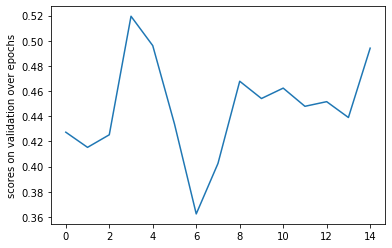

Best score =  0.5194805194805195


In [8]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=256,
     num_layers=3,
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

In [9]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=512, 
     num_layers=3,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

In [ ]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=3,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.001,
     number_of_output_classes=2)

In [ ]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=256, 
     num_layers=2,
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

In [ ]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=64, 
     num_layers=3,
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

### Second iterations round (small changed of the best from the previous round)

### Evaluation of the best LSTM model on binary problem

In [ ]:
evaluate_on_test('models/LSTM_54.09_number_of_output_classes_2_method_fixed_length_2d_L_30_size_128_num_layers_2_dropout_0.5_prediction_method_sum_equalize_training_classes_True_learnig_rate_0.0001.model',                 
                 dataset=binary_dataset,
                 size=128,
                 num_layers=2,
                 dropout=0.5,
                 L=30,
                 prediction_method='sum',
                 method='fixed_length_2d',
                 number_of_output_classes=2)